# Importing all necessary libraries

In [1]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.2 MB/s eta 0:00:00


In [2]:
# For reading our dataset
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

# For warnings
import warnings
warnings.filterwarnings(action='ignore')

# Importing necessary packages for building and tuning our model
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from imblearn.under_sampling import NearMiss               # For Undersampling
from imblearn.over_sampling import RandomOverSampler       # For Oversampling
from imblearn.combine import SMOTETomek                    # For Both Undersampling & Oversampling
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras_tuner.tuners import RandomSearch

# For checking acuracy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Accessing the dataset
dataset_path = "/content/drive/MyDrive/dataset/loan.csv"

Mounted at /content/drive


In [4]:
# Reading the dataset
df_read=pd.read_csv(dataset_path,low_memory=False)    # Setting low_memory=False to avoid DtypeWarning for columns with mixed data types
print("Shape of the dataset:",df_read.shape)
df_read.head()

Shape of the dataset: (887379, 74)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### NOTE:- As we can see there are too many features, 74 to be exact in which many of them are useless so we have to minimize the features available. So let's start

In [5]:
df_read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

### There seems to be many columns with null values. So let's first write a simple lines of code to identify the percentage of null values in each column in order to drop certain columns that don't meet a percentage threshold.

## Data Cleaning

In [6]:
# Calculate the percentage of missing values in df_read
percentage_missing = df_read.isnull().sum() / len(df_read) * 100

# Create a new DataFrame with columns from df and index set to None
new_df = pd.DataFrame(columns=df_read.columns, index=None)
pd.set_option('display.max_columns', None)

# Creating new Percentage index
new_df.loc['Percentage'] = percentage_missing.values
new_df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
Percentage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.799326,5.051393,0.0,0.000451,0.0,0.0,0.0,0.0,0.0,85.797726,0.0,0.017129,0.0,0.0,0.0,0.003268,0.003268,0.003268,51.197065,84.555303,0.003268,0.003268,0.0,0.056571,0.003268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.990018,0.0,28.507661,0.005973,0.01634,75.015974,0.0,0.0,99.942415,99.94264,99.942415,0.003268,7.919502,7.919502,97.591559,97.591559,97.591559,97.591559,97.654892,97.591559,97.902024,97.591559,97.591559,97.591559,97.591559,7.919502,97.591559,97.591559,97.591559


In [7]:
# Keeping only those features with less than 20% of missing values
features_to_keep = df_read.columns[((df_read.isnull().sum()/len(df_read))*100 < 20)].to_list()
print("Total features before:",len(df_read.columns))
print("Total features now:",len(features_to_keep))

Total features before: 74
Total features now: 52


In [8]:
df1=df_read[features_to_keep]
df1.shape

(887379, 52)

### Previously our dataset had more features than a toolbox, but we've managed to narrow it down from 74 to 52. However, that still wasn't enough, so we called upon the mystical powers of a random expert in this field. They gave us their blessing and bestowed upon us the 20 most fortunate features, which we will now use for further analysis

In [9]:
lucky_features=['loan_amnt','term', 'int_rate', 'installment', 'grade', 'sub_grade','emp_length','home_ownership',
                'annual_inc','verification_status','purpose','dti','delinq_2yrs','inq_last_6mths','open_acc',
                'pub_rec','revol_bal','revol_util','total_acc','last_pymnt_amnt','loan_status']
print(len(lucky_features))

21


#####  So now that we have chosen our features let's proceed to describe each one of them
### **Loan Dataset Columns**
#### **Loan Information**
- **loan_amnt**: the amount of the loan
- **term**: the term of the loan (36 or 60 months)
- **int_rate**: the interest rate of the loan
- **installment**: the monthly payment of the loan

#### **Borrower Information**
- **grade**: the grade assigned by LendingClub based on the creditworthiness of the borrower
- **sub_grade**: a more detailed grade based on the borrower's creditworthiness
- **emp_length**: the length of employment of the borrower
- **home_ownership**: the type of home ownership of the borrower
- **annual_inc**: the annual income of the borrower
- **verification_status**: whether the income was verified by LendingClub

#### **Loan Details**
- **purpose**: the purpose of the loan
- **dti**: the debt-to-income ratio of the borrower
- **delinq_2yrs**: the number of delinquencies in the past 2 years
- **inq_last_6mths**: the number of inquiries in the last 6 months
- **open_acc**: the number of open credit lines in the borrower's credit file
- **pub_rec**: the number of derogatory public records
- **revol_bal**: the total credit revolving balance
- **revol_util**: the amount of credit the borrower is using relative to their total credit limit
- **total_acc**: the total number of credit lines in the borrower's credit file
- **last_pymnt_amnt**: the last payment amount received

In [10]:
df=df1[lucky_features]
print("Shape of the dataset:",df.shape)
df.head()

Shape of the dataset: (887379, 21)


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_pymnt_amnt,loan_status
0,5000.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,credit_card,27.65,0.0,1.0,3.0,0.0,13648.0,83.7,9.0,171.62,Fully Paid
1,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,car,1.00,0.0,5.0,3.0,0.0,1687.0,9.4,4.0,119.66,Charged Off
2,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,small_business,8.72,0.0,2.0,2.0,0.0,2956.0,98.5,10.0,649.91,Fully Paid
3,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,other,20.00,0.0,1.0,10.0,0.0,5598.0,21.0,37.0,357.48,Fully Paid
4,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,80000.0,Source Verified,other,17.94,0.0,0.0,15.0,0.0,27783.0,53.9,38.0,67.79,Current


In [11]:
df.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_pymnt_amnt
count,887379.000000,887379.000000,887379.000000,8.873750e+05,887379.000000,887350.000000,887350.000000,887350.000000,887350.000000,8.873790e+05,886877.000000,887350.000000,887379.000000
mean,14755.264605,13.246740,436.717127,7.502759e+04,18.157039,0.314442,0.694623,11.548469,0.195307,1.692079e+04,55.067693,25.268026,2164.145585
std,8435.455601,4.381867,244.186593,6.469830e+04,17.190626,0.862244,0.998448,5.317313,0.582091,2.242679e+04,23.834344,11.840561,4794.783233
min,500.000000,5.320000,15.670000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000
25%,8000.000000,9.990000,260.705000,4.500000e+04,11.910000,0.000000,0.000000,8.000000,0.000000,6.443000e+03,37.700000,17.000000,280.170000
50%,13000.000000,12.990000,382.550000,6.500000e+04,17.650000,0.000000,0.000000,11.000000,0.000000,1.187500e+04,56.000000,24.000000,462.780000
75%,20000.000000,16.200000,572.600000,9.000000e+04,23.950000,0.000000,1.000000,14.000000,0.000000,2.082900e+04,73.600000,32.000000,831.245000
max,35000.000000,28.990000,1445.460000,9.500000e+06,9999.000000,39.000000,33.000000,90.000000,86.000000,2.904836e+06,892.300000,169.000000,36475.590000


Since 'loan_status' is the target variavle therefore it is important to explore this feature.

In [12]:
df_read['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'],
      dtype=object)

### As we can see there are so many labels in loan_status but i want my model to predict whether the loan was full paid or charged off. So <u>in my case</u> I am selecting only those samples that have loan status either full paid or charged off.

In [13]:
target_loan= ["Fully Paid","Charged Off"]
df=df[df["loan_status"].isin(target_loan)]
print(df.shape)

(252971, 21)


### You can choose any combination of labels for your model.

### For example :- If you want your model to predict whether the person that has taken the loan is a defaulter or not. For this case make the 'Default' label as 1 and rest as 0 to create a binary classification problem.

#### --> 'loan_status' column's labels information:

- Fully Paid: The loan has been fully paid off by the borrower.
- Charged Off: The loan has not been fully repaid and Lending Club has charged off the remaining balance as a loss.
- Current: The loan is currently being repaid on schedule.
- Default: The borrower has failed to make payments on the loan and the loan is in default.
- Late (31-120 days): The borrower has missed payments and is between 31 and 120 days late on their payment schedule.
- In Grace Period: The borrower is in a grace period and has missed a payment.
- Late (16-30 days): The borrower has missed a payment and is between 16 and 30 days late on their payment schedule.
- Does not meet the credit policy. Status:Fully Paid: The loan has been fully paid off, but did not meet Lending Club's credit underwriting policy.
- Does not meet the credit policy. Status:Charged Off: The loan did not meet Lending Club's credit underwriting policy and has been charged off as a loss.
- Issued: The loan has been issued but has not yet been funded by investors.

## Explorarotry Data Analysis

In [14]:
df.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
sub_grade                 0
emp_length             9897
home_ownership            0
annual_inc                0
verification_status       0
purpose                   0
dti                       0
delinq_2yrs               0
inq_last_6mths            0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util              199
total_acc                 0
last_pymnt_amnt           0
loan_status               0
dtype: int64

### Handling null values

In [15]:
df['emp_length']=df['emp_length'].fillna(df['emp_length'].mode()[0])
df['revol_util']=df['revol_util'].fillna(df['revol_util'].median())

### Visualization

Text(0.5, 1.0, 'Loan status count')

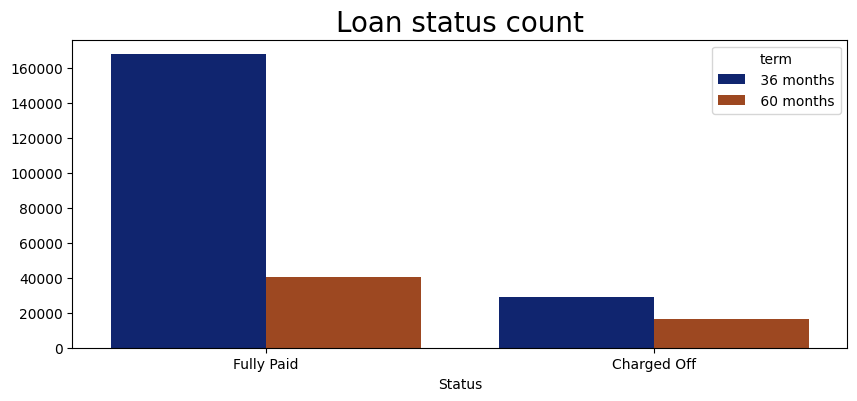

In [16]:
fig, ax =plt.subplots(figsize=(10,4))
sns.countplot(data=df,x="loan_status",hue="term",palette='dark')
ax.set(xlabel='Status', ylabel='')
ax.set_title('Loan status count', size=20)

Text(0.5, 1.0, 'Loan status count')

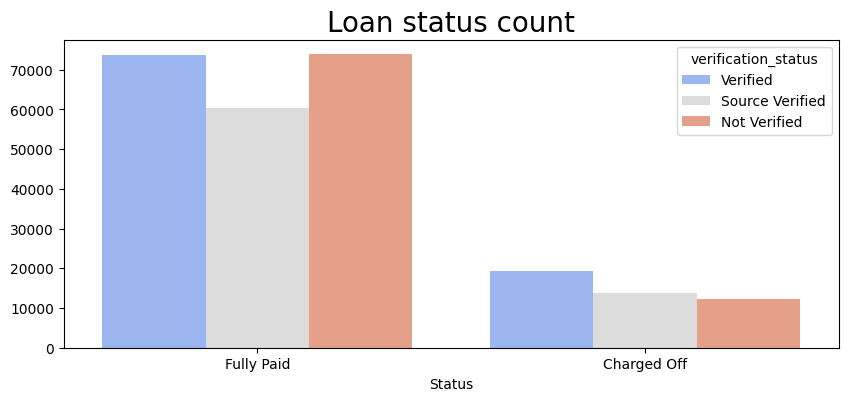

In [17]:
fig, ax =plt.subplots(figsize=(10,4))
sns.countplot(data=df,x="loan_status",hue="verification_status",palette='coolwarm')
ax.set(xlabel='Status', ylabel='')
ax.set_title('Loan status count', size=20)

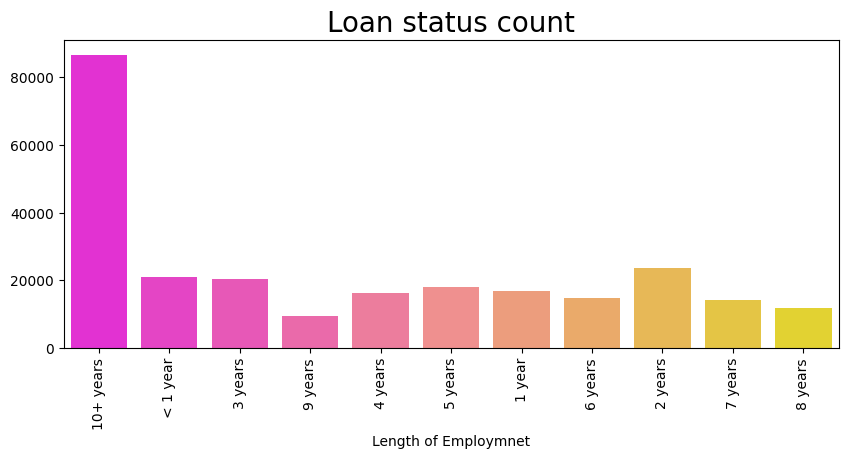

In [18]:
fig, ax =plt.subplots(figsize=(10,4))
sns.countplot(data=df,x="emp_length",palette='spring')
ax.set(xlabel='Length of Employmnet', ylabel='')
ax.set_title('Loan status count', size=20)
plt.xticks(rotation='vertical')
plt.show()

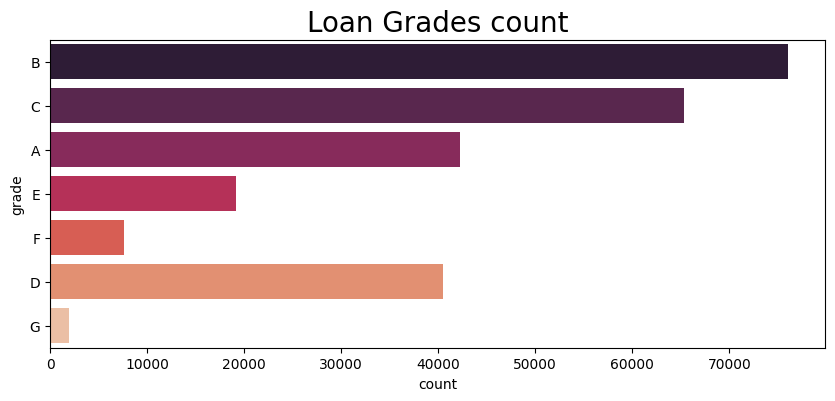

In [19]:
fig, ax =plt.subplots(figsize=(10,4))
sns.countplot(data=df,y="grade",palette='rocket')
ax.set_title('Loan Grades count', size=20)
plt.show()

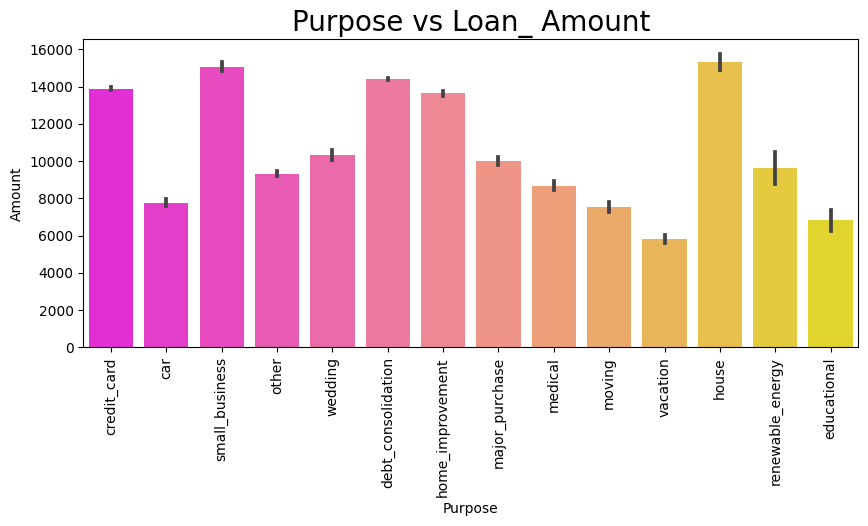

In [20]:
fig, ax =plt.subplots(figsize=(10,4))
sns.barplot(data=df,x="purpose",y='loan_amnt',palette='spring')
ax.set(xlabel='Purpose', ylabel='Amount')
ax.set_title('Purpose vs Loan_ Amount', size=20)
plt.xticks(rotation='vertical')
plt.show()

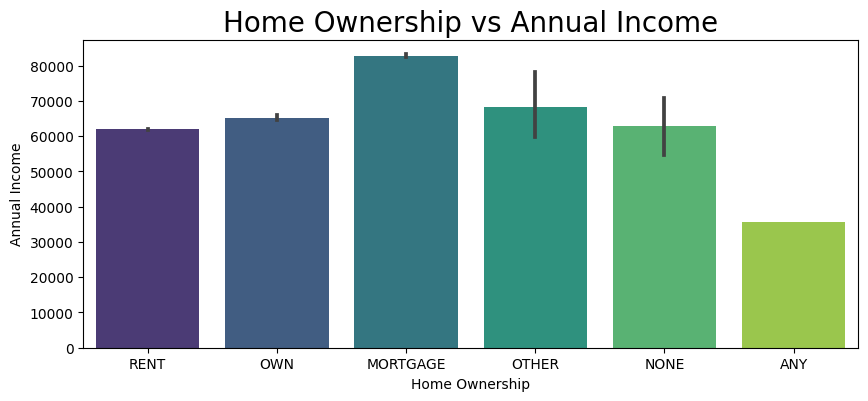

In [21]:
fig, ax =plt.subplots(figsize=(10,4))
sns.barplot(data=df,x="home_ownership",y='annual_inc',palette='viridis')
ax.set(xlabel='Home Ownership', ylabel='Annual Income')
ax.set_title('Home Ownership vs Annual Income', size=20)
plt.show()

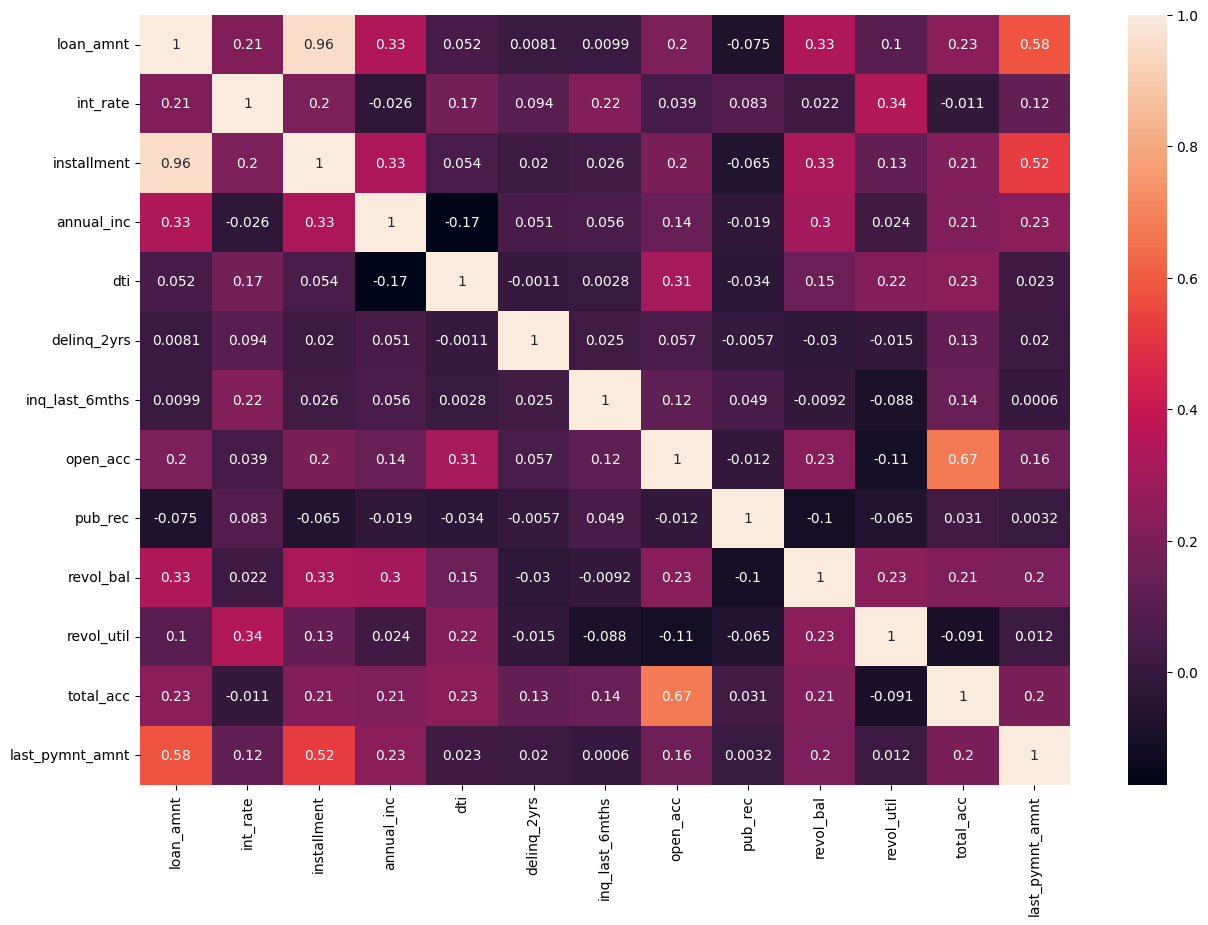

In [22]:
# Plotting a heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [23]:
# Dividing our features into categorical and numerical
categorical=[feature for feature in df.columns if df[feature].dtype=='object']
numerical=[feature for feature in df.columns if feature not in categorical]

In [24]:
print("Categorical columns:",categorical)
print("Numerical columns:",numerical)

Categorical columns: ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'loan_status']
Numerical columns: ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'last_pymnt_amnt']


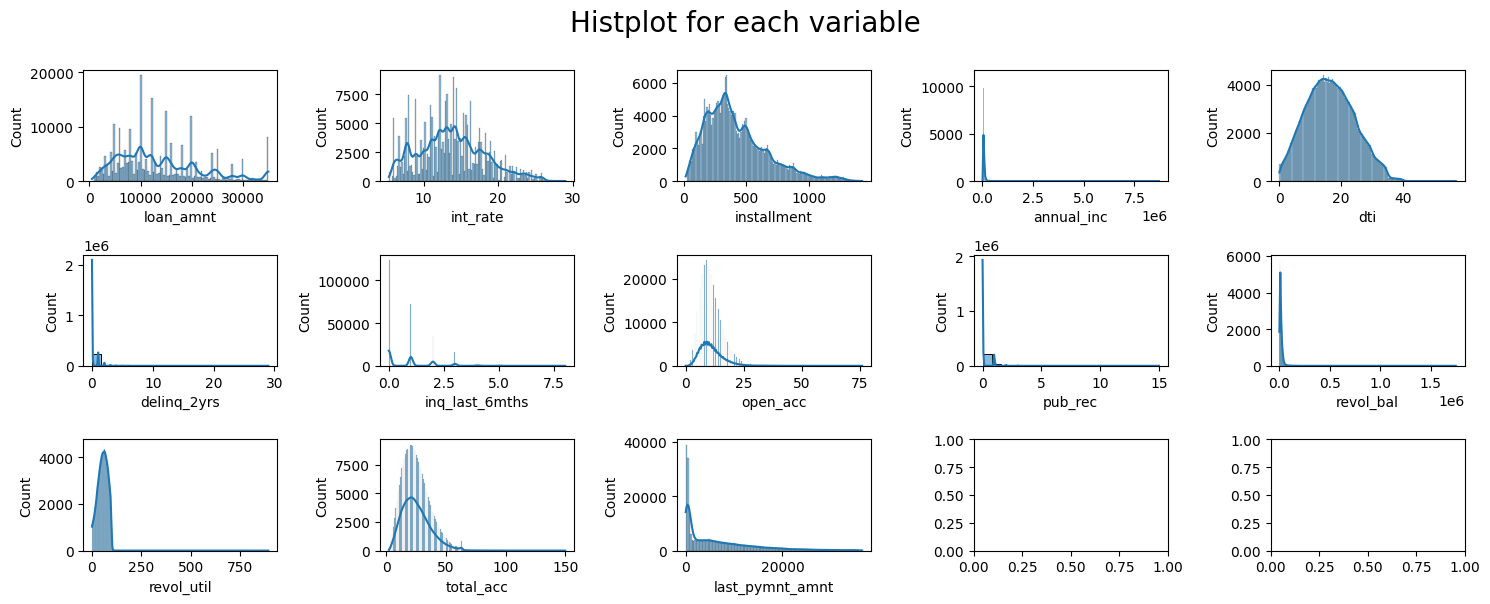

In [25]:
# Histplot for each variable in numerical list
def histplot_visual(data,column):
    fig, ax = plt.subplots(3,5,figsize=(15,6))
    fig.suptitle('Histplot for each variable',y=1, size=20)
    ax=ax.flatten()
    for i,feature in enumerate(column):
        sns.histplot(data=data[feature],ax=ax[i], kde=True)
histplot_visual(data=df,column=numerical)
plt.tight_layout()

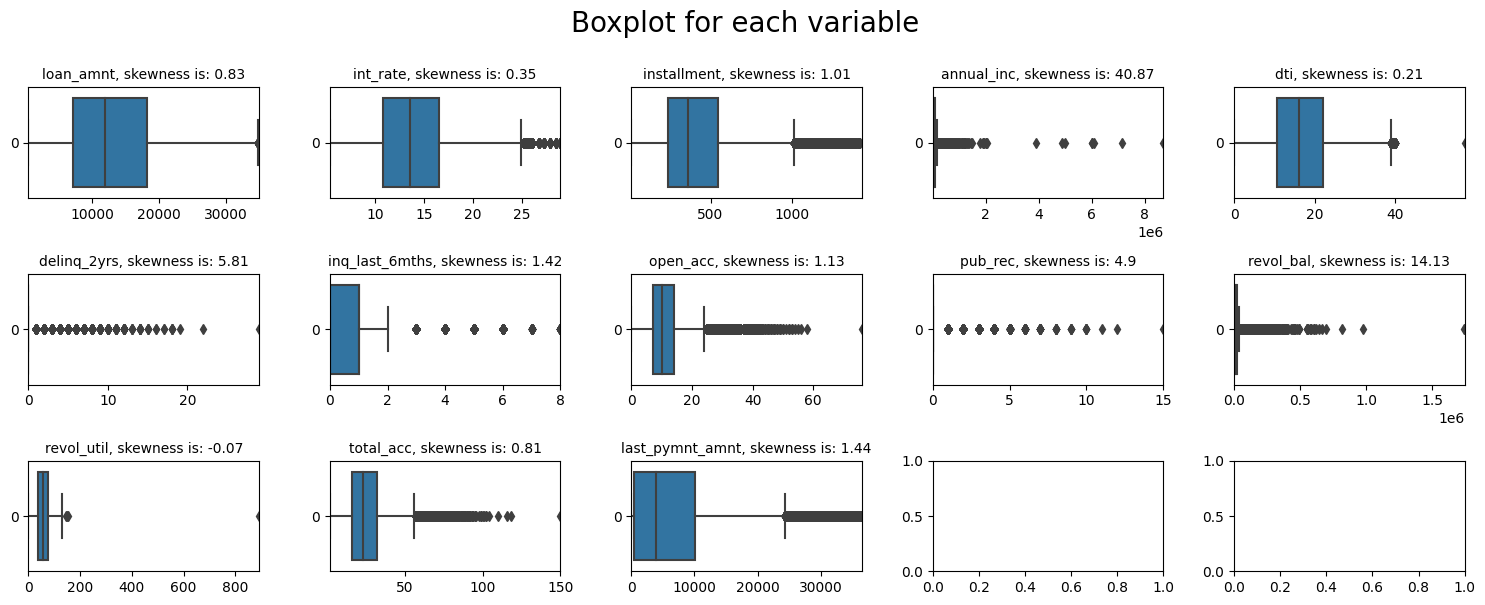

In [26]:
# Boxplot for each variable in numerical list
def boxplots_visual(data,column):
    fig, ax = plt.subplots(3,5,figsize=(15,6))
    fig.suptitle('Boxplot for each variable',y=1, size=20)
    ax=ax.flatten()
    for i,feature in enumerate(column):
        sns.boxplot(data=data[feature],ax=ax[i], orient='h')
        ax[i].set_title(feature+ ', skewness is: '+str(round(data[feature].skew(axis = 0, skipna = True),2)),fontsize=10)
        ax[i].set_xlim([min(data[feature]), max(data[feature])])
boxplots_visual(data=df,column=numerical)
plt.tight_layout()

### Preprocessing

In [27]:
# Term column
print("Before:",df['term'].unique())
df['term'] = df['term'].map(lambda x: x.lstrip(' ').rstrip(' months'))
print("After:",df['term'].unique())
df['term']=df['term'].astype('int64')

Before: [' 36 months' ' 60 months']
After: ['36' '60']


In [28]:
# emp_length column
print("Before:",df['emp_length'].unique())
df['emp_length']= df['emp_length'].str.replace(r'[a-zA-Z]','')
df['emp_length']= df['emp_length'].str.replace(' ','')
print("After:",df['emp_length'].unique())

Before: ['10+ years' '< 1 year' '3 years' '9 years' '4 years' '5 years' '1 year'
 '6 years' '2 years' '7 years' '8 years']
After: ['10+' '<1' '3' '9' '4' '5' '1' '6' '2' '7' '8']


In [29]:
# Creating a pickle file for the TfidfVectorizer
with open('dataset.pkl', 'wb') as f:
    pickle.dump(df, f)

In [30]:
# Label Encoding
df['grade']= df['grade'].map({'A':0,'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6})

df['sub_grade']= df['sub_grade'].map({'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3, 'A5': 4, 
                                      'B1': 5, 'B2': 6, 'B3': 7, 'B4': 8, 'B5': 9, 
                                      'C1': 10, 'C2': 11, 'C3': 12, 'C4': 13, 'C5': 14, 
                                      'D1': 15, 'D2': 16, 'D3': 17, 'D4': 18, 'D5': 19, 
                                      'E1': 20, 'E2': 21, 'E3': 22, 'E4': 23, 'E5': 24, 
                                      'F1': 25, 'F2': 26, 'F3': 27, 'F4': 28, 'F5': 29, 
                                      'G1': 30, 'G2': 31, 'G3': 32, 'G4': 33, 'G5': 34})

df['emp_length']= df['emp_length'].map({'<1': 0,'1': 1,'2': 2,'3': 3,
                                        '4': 4, '5': 5,'6': 6,'7': 7,
                                        '8': 8,'9': 9, '10+': 10})

df['loan_status']= df['loan_status'].map({'Fully Paid':0, 'Charged Off':1})

In [31]:
# One hot encoding
df=pd.get_dummies(data=df,columns=['home_ownership','verification_status','purpose'],drop_first=True)
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_pymnt_amnt,loan_status,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,5000.0,36,10.65,162.87,1,6,10,24000.0,27.65,0.0,1.0,3.0,0.0,13648.0,83.7,9.0,171.62,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2500.0,60,15.27,59.83,2,13,0,30000.0,1.00,0.0,5.0,3.0,0.0,1687.0,9.4,4.0,119.66,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2400.0,36,15.96,84.33,2,14,10,12252.0,8.72,0.0,2.0,2.0,0.0,2956.0,98.5,10.0,649.91,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,10000.0,36,13.49,339.31,2,10,10,49200.0,20.00,0.0,1.0,10.0,0.0,5598.0,21.0,37.0,357.48,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,5000.0,36,7.90,156.46,0,3,3,36000.0,11.20,0.0,3.0,9.0,0.0,7963.0,28.3,12.0,161.03,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Model Training

In [32]:
# Dividing our dataset into independent and dependent features
X=df.drop('loan_status',axis=1)
y=df['loan_status']

In [33]:
# Splitting our dataset between training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=100)

In [34]:
# MinMax Scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
df['loan_status'].value_counts()

0    207723
1     45248
Name: loan_status, dtype: int64

Let's look at the percentage of each category in our target column before model training.

In [38]:
print("Fully Paid:",df['loan_status'].value_counts()[0]/len(df['loan_status'])*100)
print("Charged Off:",df['loan_status'].value_counts()[1]/len(df['loan_status'])*100)

Fully Paid: 82.11336477303722
Charged Off: 17.886635226962774


It's time to apply some resampling techniques !!!

# Handling Imbalanced Dataset

## UnderSampling

In [39]:
ns=NearMiss()
X_train_ns,y_train_ns=ns.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

The number of classes before fit Counter({0: 155708, 1: 34020})
The number of classes after fit Counter({0: 34020, 1: 34020})


In [40]:
model1=RandomForestClassifier()
model1.fit(X_train_ns,y_train_ns)

RandomForestClassifier()

In [41]:
y_pred=model1.predict(X_test)
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

Confusion Matrix: 
 [[35896 16119]
 [ 1389  9839]]


Accuracy Score: 
 0.7231630378065557


Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.69      0.80     52015
           1       0.38      0.88      0.53     11228

    accuracy                           0.72     63243
   macro avg       0.67      0.78      0.67     63243
weighted avg       0.86      0.72      0.76     63243



## OverSampling

In [42]:
from imblearn.over_sampling import RandomOverSampler
os=RandomOverSampler()
X_train_os,y_train_os=os.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_os)))

The number of classes before fit Counter({0: 155708, 1: 34020})
The number of classes after fit Counter({0: 155708, 1: 155708})


In [43]:
model2=RandomForestClassifier()
model2.fit(X_train_os,y_train_os)

RandomForestClassifier()

In [44]:
y_pred=model2.predict(X_test)
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

Confusion Matrix: 
 [[48777  3238]
 [ 2397  8831]]


Accuracy Score: 
 0.9108992299543033


Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.94      0.95     52015
           1       0.73      0.79      0.76     11228

    accuracy                           0.91     63243
   macro avg       0.84      0.86      0.85     63243
weighted avg       0.91      0.91      0.91     63243



## SMOTETomek(Do both undersampling and oversampling)

In [43]:
smt=SMOTETomek()
X_train_smt,y_train_smt=smt.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_smt)))

The number of classes before fit Counter({0: 155708, 1: 34020})
The number of classes after fit Counter({0: 155138, 1: 155138})


In [44]:
model3=RandomForestClassifier()
model3.fit(X_train_smt,y_train_smt)

RandomForestClassifier()

In [48]:
y_pred=model3.predict(X_test)
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

Confusion Matrix: 
 [[48084  3931]
 [ 2098  9130]]


Accuracy Score: 
 0.9046692914630868


Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     52015
           1       0.70      0.81      0.75     11228

    accuracy                           0.90     63243
   macro avg       0.83      0.87      0.85     63243
weighted avg       0.91      0.90      0.91     63243



Overall oversampling has the best result so we will go with oversampling

#### Hyperparameter Tuning with Keras Tuner

In [45]:
# Define the build_model function for Keras Tuner
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

### Explanation of my 'build_model' function for the Keras Tuner
- This function takes in the hyperparameters defined by the tuner and returns a compiled Keras model.
- The function defines a Keras Sequential model and adds a variable number of Dense layers (between 2 and 20) with a variable number of units (between 32 and 512).
- The output layer has one unit with a sigmoid activation function(Because it's a classification problem).
- The function compiles the model using binary crossentropy as the loss function and the Adam optimizer with a learning rate that is randomly chosen from [1e-2, 1e-3, 1e-4].

In [46]:
tuner = RandomSearch(                   # The tuner uses the build_model function defined earlier as its model-building function,
    build_model,                        # and searches for the best hyperparameters based on validation accuracy.
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=2)
tuner.search(X_train_os, y_train_os, epochs=10, validation_data=(X_test, y_test))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]                # Storing my best hyperparameters in the best_hps variable.

Trial 3 Complete [00h 20m 48s]
val_accuracy: 0.8632022440433502

Best val_accuracy So Far: 0.8714244961738586
Total elapsed time: 01h 04m 27s


### Now's the hightime to actually start building our model

In [47]:
# Define the create_model function to build a Keras model with the optimal hyperparameters
def create_model(num_layers, num_nodes, activation):
    model = keras.Sequential()
    for i in range(num_layers):
        if i==0:                                                           # checks whether the current layer is the first layer of the model.
            model.add(layers.Dense(num_nodes[i], input_dim=X_train.shape[1]))
            model.add(layers.Activation(activation))
            model.add(layers.Dropout(0.3))
        else:
            model.add(layers.Dense(num_nodes[i]))
            model.add(layers.Activation(activation))
            model.add(layers.Dropout(0.3))       
    model.add(layers.Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Generate a list of integers for the number of nodes in each layer
num_nodes = [best_hps.get('units_' + str(i)) for i in range(best_hps.get('num_layers'))]

model = KerasClassifier(
    build_fn=create_model,
    num_layers=best_hps.get('num_layers'),
    num_nodes=num_nodes,
    activation='relu'
)

### Explanation of my 'create_model' function
- This function uses the best hyperparameters obtained from the tuner.
- This function takes in three arguments- num_layers, num_nodes and activation which are used to build the model with the given number of layers and activation function for each layer.
- The model object is created using the keras.Sequential() method.
- A loop is run over the layers to add the dense layers to the model.
- In the first iteration, a check is performed to see if the current layer is the first layer of the model. If yes, input_dim is added as the input shape for the layer
- The num_nodes variable is a list of integers representing the number of nodes in each layer of the model, extracted from the best hyperparameters dictionary.
- An activation function and a dropout layer is added after each dense layer. The activation argument is used to specify the activation function for each layer.
- The output layer is added with a sigmoid activation function and binary crossentropy loss function. The model is then compiled using the adam optimizer.

### Finally, we use the KerasClassifier class from scikit-learn to wrap the create_model function and create a scikit-learn compatible estimator.

In [48]:
# Fit the Keras Classifier model with the optimal hyperparameters
mymodel= model.fit(X_train_os, y_train_os, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
9732/9732 [==============================] - 69s 7ms/step - loss: 0.3104 - accuracy: 0.8740 - val_loss: 0.2510 - val_accuracy: 0.8499
Epoch 2/20
9732/9732 [==============================] - 67s 7ms/step - loss: 0.2856 - accuracy: 0.8875 - val_loss: 0.2680 - val_accuracy: 0.8541
Epoch 3/20
9732/9732 [==============================] - 66s 7ms/step - loss: 0.2837 - accuracy: 0.8890 - val_loss: 0.2554 - val_accuracy: 0.8639
Epoch 4/20
9732/9732 [==============================] - 65s 7ms/step - loss: 0.2893 - accuracy: 0.8879 - val_loss: 0.2492 - val_accuracy: 0.8507
Epoch 5/20
9732/9732 [==============================] - 65s 7ms/step - loss: 0.2855 - accuracy: 0.8879 - val_loss: 0.2396 - val_accuracy: 0.8738
Epoch 6/20
9732/9732 [==============================] - 66s 7ms/step - loss: 0.2826 - accuracy: 0.8887 - val_loss: 0.2382 - val_accuracy: 0.8468
Epoch 7/20
9732/9732 [==============================] - 67s 7ms/step - loss: 0.2828 - accuracy: 0.8882 - val_loss: 0.2587 - val_ac

In [49]:
y_pred=model.predict(X_test)
y_pred = (y_pred > 0.5)

1977/1977 [==============================] - 4s 2ms/step


In [50]:
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_pred))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_pred))

Confusion Matrix: 
 [[45170  6845]
 [ 1160 10068]]


Accuracy Score: 
 0.87342472684724


Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.87      0.92     52015
           1       0.60      0.90      0.72     11228

    accuracy                           0.87     63243
   macro avg       0.79      0.88      0.82     63243
weighted avg       0.91      0.87      0.88     63243



In [52]:
# Save the model
# with open('my_model.pkl', 'wb') as file:
#     pickle.dump(model, file)
model.model.save('my_model.h5')

### So that's it while the overall accuracy of the model is good at 87%, the precision and f1-score for class 1 (lending loans that are not paid back) are relatively low compared to class 0 (lending loans that are paid back). This means that the model is better at predicting loans that will be paid back than loans that will not be paid back.
### This can be due to the imbalancy b/w the classes(0 & 1) in the dataset which may have contributed to this issue, and that further analysis or adjustments to the model may be necessary to improve its performance on predicting class 1.

In [53]:
# Checkingif the model is working fine or not
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('my_model.h5')

# Use the model to make predictions on X_test
y_pred = model.predict(X_test)

# Print the predicted values
print(y_pred)

1977/1977 [==============================] - 3s 2ms/step
[[0.01268252]
 [0.79058653]
 [0.38559973]
 ...
 [0.01270323]
 [0.73523915]
 [0.01270323]]
